In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [26]:
name = 'house'
#name = 'library'
data_dir = 'data'

# images
I1 = plt.imread(data_dir + '/' + name + '/house1.jpg')
I2 = plt.imread(data_dir + '/' + name + '/house2.jpg')

# K matrices
qq = loadmat(data_dir + '/' + name + '/house1_K.mat')
K1 = qq['K']
print(K1.shape)
qq = loadmat(data_dir + '/' + name + '/house2_K.mat')
K2 = qq['K']

# corresponding points
matches = [x.split('  ')[1:] for x in open(data_dir + '/' + name + '/house_matches.txt').readlines()] 
matches = [[float(y) for y in x] for x in matches]
matches = np.array(matches)

# this is a N x 4 where:
# matches(i,1:2) is a point in the first image
# matches(i,3:4) is the corresponding point in the second image

(3, 3)


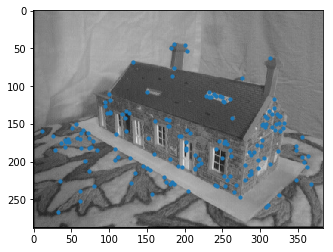

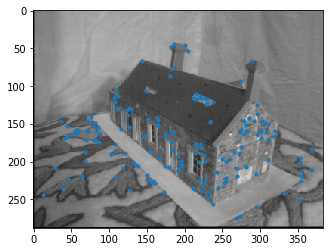

matches shape: (168, 4)


In [27]:

plt.imshow(I1)
plt.scatter(matches[:, 0], matches[:, 1], s = 10)
plt.show()
plt.imshow(I2)
plt.scatter(matches[:, 2], matches[:, 3], s = 10)
plt.show()
print("matches shape:", matches.shape)

In [32]:
'''The function that returns the fundamental matrix described in 1.4.1 (Eight Point Algorithm).
This function takes in atleast 8 corresponding points and returns the matrix F and the residual.
'''
def fundamental_matrix(matches):
    #TODO (do this with normalization)

    # normalize
    
    # write mean + std transformations as matrices
    set1 = matches[:, 0:2]
    set2 = matches[:, 2:4]
    
    """mean_fn1, std_fn1 = get_normalize_fns(set1)
    mean_fn2, std_fn2 = get_normalize_fns(set2)"""
    T_1 = get_normalize_mat(set1)
    T_2 = get_normalize_mat(set2)
    set1 = normalize(set1, T_1)
    set2 = normalize(set2, T_2)
    #print(set1)
    A = np.stack(
        [set1[:, 0] * set2[:, 0],
         set1[:, 1] * set2[:, 0],
         set2[:, 0],
         set1[:, 0] * set2[:, 1],
         set1[:, 1] * set2[:, 1],
         set2[:, 1],
         set1[:, 0],
         set1[:, 1],
         np.ones(set1[:, 0].shape)], axis=1)
    U, s, Vh = np.linalg.svd(A)
    F_star = Vh[-1].reshape(3, 3)
    U, s, Vh = np.linalg.svd(F_star)
    s[2] = 0
    return T_2.T @ U @ np.diag(s) @ Vh @ T_1

##Josh Added
'''
This function gets the normalization matrix that can be applied to a data point in HOMOGENOUS
coordinates
'''
def get_normalize_mat(s):
    mu = np.mean(s, axis=0)
    sigma = np.std(np.linalg.norm(s, axis=1))
    return 1/sigma * np.array([[1, 0 ,-mu[0]],
                               [0, 1, -mu[1]],
                               [0, 0,  sigma]])
####

# def normalize(s):
#     return (s - np.mean(s, axis=1).reshape(s.shape[0], 1)) / \
#             np.std(s, axis=1).reshape(s.shape[0], 1)
'''
This normalization method converts to homogenous coordinates to use the tranformation T.
I think this is the correct way
'''
def normalize(s, T):
    ones = np.ones(s.T[0].shape)
    s_prime = np.stack([s.T[0], s.T[1], ones], axis=0)
    return (T @ s_prime).T[:,:2]

def get_normalize_fns(s):
    mean = np.mean(s, axis=0)
    std = np.std(s, axis=0)
    s_homogenous = np.stack([s, np.ones(s.shape[0], 1)], axis=1).T
    
    mean_transformation = np.eye(3)
    mean_transformation[1]
    std_transformation = np.diag(1 / std)

'''Given E, calculates and returns both the rotation and translation between the two cameras.
Described in part 1.4.2. Returning the magnitude of t is impossible, so we return
an array of possible t's and an array of possible R's.
'''
def find_rotation_translation(E):
    U, Sigma, Vh = np.linalg.svd(E)
    S = U
    print(Sigma)
    #the two singular values should be the SAME
    R90_St_R = Vh
    R90t = np.array([[0, -1, 0],
                     [1, 0, 0],
                     [0, 0, 1]])
    R = S @ R90t.T @ R90_St_R
    
    t = S[:, 2]
    return [t, -t], [R, -R]

'''Triangulation function. This takes in the matches, P1, P2, and
finds the best 3D points that reproject to the images in the
two cameras.

This returns a Nx3 matrix of points in 3D space and the 
reconstruction scene. N depends on the number of points
that end up in front of the images planes.'''
def find_3d_points(matches, P1, P2):
    #TODO
#    def get_X_and_err(x1, x2):
#         A = np.array([[(P1[0,0] - x1[0]*P1[2,0]), (P1[0,1] - x1[0]*P1[2,1]), (P1[0,2] - x1[0]*P1[2,2])],
#                       [(P1[1,0] - x1[1]*P1[2,0]), (P1[1,1] - x1[1]*P1[2,1]), (P1[1,2] - x1[1]*P1[2,2])],
#                       [(P2[0,0] - x2[0]*P2[2,0]), (P2[0,1] - x2[0]*P2[2,1]), (P2[0,2] - x2[0]*P2[2,2])],
#                       [(P2[1,0] - x2[1]*P2[2,0]), (P2[1,1] - x2[1]*P2[2,1]), (P2[1,2] - x2[1]*P2[2,2])]])
#         b = np.array([[P1[0, 3] - x1[0]*P1[2, 3]],
#                       [P1[1, 3] - x1[1]*P1[2, 3]],
#                       [P2[0, 3] - x2[0]*P2[2, 3]],
#                       [P2[1, 3] - x2[1]*P2[2, 3]]])
#         X = np.linalg.lstsq(A, b)[0]
#         X_hom = np.append(X, 1)
#         x1_p = P1 @ X_hom
#         x1_p = (x1_p/x1_p[2])[:2]
#         x2_p = P2 @ X_hom
#         x2_p = (x2_p/x2_p[2])[:2]

#         err1 = np.linalg.norm(x1_p - x1)
#         err2 = np.linalg.norm(x2_p - x2)
#         print(x2, x2_p)
        
#         if (X[2] < 0):
#             return None
#         #print(err1, err2)
#         return X, (err1 + err2)/2
    def get_X_and_err(x1, x2):
        A = np.array([[(P1[0,0] - x1[0]*P1[2,0]), (P1[0,1] - x1[0]*P1[2,1]), (P1[0,2] - x1[0]*P1[2,2])],
                      [(P1[1,0] - x1[1]*P1[2,0]), (P1[1,1] - x1[1]*P1[2,1]), (P1[1,2] - x1[1]*P1[2,2])],
                      [(P2[0,0] - x2[0]*P2[2,0]), (P2[0,1] - x2[0]*P2[2,1]), (P2[0,2] - x2[0]*P2[2,2])],
                      [(P2[1,0] - x2[1]*P2[2,0]), (P2[1,1] - x2[1]*P2[2,1]), (P2[1,2] - x2[1]*P2[2,2])]])
        b = np.array([[P1[0, 3] - x1[0]*P1[2, 3]],
                      [P1[1, 3] - x1[1]*P1[2, 3]],
                      [P2[0, 3] - x2[0]*P2[2, 3]],
                      [P2[1, 3] - x2[1]*P2[2, 3]]])
        A = np.concatenate((A, b), axis=1)
        X = np.linalg.svd(A)[2][-1]
        #X = np.linalg.lstsq(A, b)[0]
        X_hom = X
        x1_p = P1 @ X_hom
        x1_p = (x1_p/x1_p[2])[:2]
        x2_p = P2 @ X_hom
        x2_p = (x2_p/x2_p[2])[:2]

        err1 = np.linalg.norm(x1_p - x1)
        err2 = np.linalg.norm(x2_p - x2)
        print(x1, x1_p)
        print(x2, x2_p)
        
        if (X[2] < 0):
            return None
        #print(err1, err2)
        return X, (err1 + err2)/2
    
    Xs = []
    errs = []
    set1 = matches[:, 0:2]
    set2 = matches[:, 2:4]
    #set1, set2 = set2, set1
    for i in range(matches.shape[0]):
        x1, x2 = set1[i], set2[i]
        curr = get_X_and_err(x1, x2)
        if curr:
            Xs.append(curr[0].T.flatten())
            errs.append(curr[1])
#     print(np.array(Xs))
    return np.array(Xs), np.average(errs)

[4.05965071e-02 4.04808730e-02 2.40351449e-20]
[260.7225 116.595 ] [260.72410157 116.63219703]
[238.0515 120.536 ] [238.05760599 120.22498215]
[228.9035 113.4955] [228.9055464 113.5454072]
[211.077 115.594] [211.08483665 115.18337795]
[131.446  68.035] [131.44659113  68.06466042]
[143.6685  66.0075] [143.67177546  65.77466415]
[202.9845 158.6075] [202.98771344 158.66179402]
[182.4115 159.3195] [182.42160635 158.87893454]
[221.154 201.907] [221.15840392 201.96322951]
[196.4895 204.488 ] [196.50206935 204.0276995 ]
[218.374  203.7655] [218.37951791 203.83530002]
[195.061 206.227] [195.07667083 205.65640413]
[204.334  239.3505] [204.34210419 239.43740274]
[173.049 240.193] [173.07042876 239.48847186]
[122.0745 133.318 ] [122.07824686 133.40012332]
[126.107 129.225] [126.11940219 128.58389732]
[ 72.5715 162.192 ] [ 72.57648642 162.28121626]
[ 85.8745 153.485 ] [ 85.88910542 152.80497359]
[107.9075 183.522 ] [107.91334083 183.61119686]
[108.354  176.3555] [108.37033967 175.66450993]
[ 57.45

[201.46  184.114] [201.46092181 184.12719965]
[182.883 184.399] [182.88571421 184.29195451]
[120.5855 142.2935] [120.5887527  142.35923056]
[124.7895 137.649 ] [124.79992316 137.13627228]
[ 93.9425 121.038 ] [ 93.94482726 121.09561367]
[106.9585 115.6455] [106.9666371 115.2016317]
[101.3785 135.91  ] [101.37976836 135.9369537 ]
[111.8925 130.0025] [111.89668462 129.79413663]
[160.146  189.8015] [160.14514079 189.78941431]
[152.271  186.1415] [152.26852943 186.2375668 ]
[ 60.907 170.197] [ 60.91106231 170.26565489]
[ 72.6105 159.8715] [ 72.62214628 159.35128129]
[250.6245 119.5795] [250.62755521 119.64808965]
[228.591 123.278] [228.60245335 122.70745774]
[252.609  175.6295] [252.61565162 175.72577703]
[220.035  181.0805] [220.05550925 180.27991242]
[260.8775 193.061 ] [260.87958136 193.08841542]
[227.1635 199.145 ] [227.16964982 198.91602898]
[241.7105 182.9895] [241.7196975  183.11712993]
[213.511 187.963] [213.53874959 186.9074744 ]
[249.0235 195.439 ] [249.0292641  195.51373434]
[219

[201.7225 181.838 ] [201.72686711 181.90134522]
[182.918  182.5985] [182.93089087 182.0848094 ]
[100.957 134.652] [100.95883556 134.69161909]
[111.764  128.8875] [111.77006725 128.58127956]
[254.076  231.8365] [254.08299805 231.91173632]
[222.4175 238.6685] [222.43680015 238.04250336]
[265.965  240.0555] [265.97144341 240.12188353]
[231.471  248.4475] [231.48864137 247.89182544]
[151.796  169.0665] [151.79765432 169.09322957]
[146.294  165.4995] [146.29896061 165.28790021]
[213.563  210.0505] [213.56469251 210.07132962]
[191.6525 211.6175] [191.65724163 211.44758452]
[180.623 195.88 ] [180.62678856 195.93126761]
[166.6745 194.5355] [166.68523475 194.12404586]
[252.612  120.2995] [252.61399208 120.34420985]
[230.1815 123.9175] [230.18893548 123.54524053]
[256.521 176.819] [256.52318784 176.85079276]
[222.752 182.041] [222.75870074 181.77607194]
[117.644  136.8565] [117.64361598 136.84855343]
[123.2695 131.588 ] [123.26822115 131.64990135]
[122.552  159.6375] [122.55618229 159.71153756]


[241.696 112.387] [241.69844272 112.44652081]
[222.381  115.2945] [222.39046559 114.80156342]
[249.9035 113.6505] [249.90577867 113.7050587 ]
[229.2485 117.0215] [229.2572976  116.56778398]
[232.3295 114.045 ] [232.33181688 114.1009538 ]
[214.043  116.4095] [214.05185993 115.94832176]
[234.7195 114.9145] [234.72185181 114.9706856 ]
[216.0425 117.4385] [216.05146126 116.97485398]
[101.5085 118.1185] [101.51028307 118.16356108]
[111.547  113.1295] [111.5533623  112.78113072]
[ 94.8935 126.631 ] [ 94.89526045 126.67199212]
[107.4125 120.886 ] [107.41851666 120.57006561]
[ 96.9845 135.6795] [ 96.98472007 135.68415786]
[109.7485 129.3455] [109.74923005 129.30956461]
[252.8825 172.167 ] [252.88581014 172.21645162]
[220.1675 177.111 ] [220.17775903 176.69967822]
[192.3835 165.3515] [192.38638074 165.39826007]
[174.6615 165.17  ] [174.67034427 164.79253677]
[ 56.088 150.654] [ 56.09088407 150.70998552]
[ 76.481  141.3075] [ 76.48981264 140.88391466]
[347.3225 184.144 ] [347.32959266 184.236636

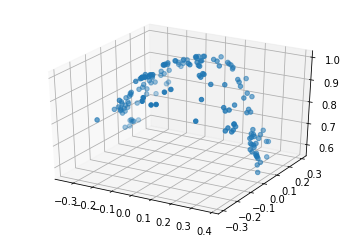

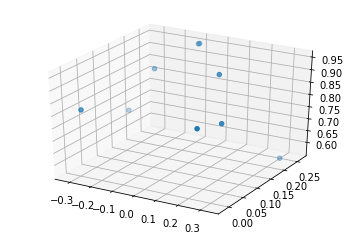

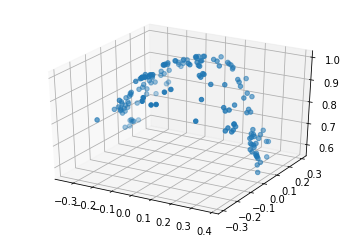

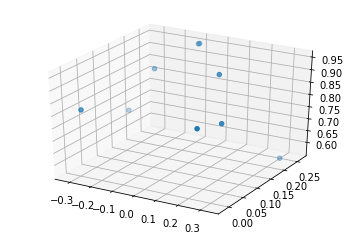

In [33]:
#TODO: visualize matches (maybe)

F = fundamental_matrix(matches)
#print('Residual in f = ', res_err)


#calculate the ESSENTIAL matrix from the FUNDAMENTAL matrix
E = K2.T @ F @ K1

# R : cell array with the possible rotation matrices of second camera
# t : cell array of the possible translation vectors of second camera
t, R = find_rotation_translation(E) 

#P1: P matrix for camera 1
#P2 is calculated on the fly since there are multiple possibilities
P1 = K1 @ np.array([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 1, 0]])

# % the number of points in front of the image planes for all combinations
num_points = np.zeros((len(t), len(R)))
# % the reconstruction error for all combinations
errs = np.full((len(t), len(R)), np.inf)

for ti in range(len(t)):
    t2 = t[ti]
    for ri in range(len(R)):
        R2 = R[ri]
        P2 = K2 @ np.column_stack((R2, t2))
        #print(P2)
        points_3d,  errs[ti, ri] = find_3d_points(matches, P1, P2) 
        if len(points_3d) == 0:
            continue
        #print("points_3d", points_3d.shape)
        #print(points_3d)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(points_3d[:, 0], points_3d[:, 1], zs=points_3d[:, 2])
        num_points[ti, ri] = points_3d.shape[0]
#print(errs)